# Micro-narrative analysis of _The Lord of the Rings_

In [1]:
import glob

import pandas as pd

docs = []
for file in glob.glob("input/*.txt"):
    with open(file) as f:
        text = f.read()
        sections = text.split("\n\n")
        for section in sections:
            section = section.strip()
            if section:
                docs.append(section)

In [2]:
from narrativegraphs import CooccurrenceGraph
import os.path

if os.path.exists("lotr.db"):
    model = CooccurrenceGraph.load("lotr.db")
else:
    model = CooccurrenceGraph(
        sqlite_db_path="lotr.db",
        on_existing_db="overwrite",
        n_cpu=1
    ).fit(docs)

In [3]:
# here, we can interactively inspect the cooccurrence graph
model.serve_visualizer()

INFO:     Started server process [21289]
INFO:     Waiting for application startup.
INFO:root:Database engine provided to state before startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [21289]
INFO:root:Server stopped


## Distribution of entities

Below, we will look at the distribution of extracted entities. As for single-word distributions, we expect to be in the central Large Number of Rare Events (LNRE) zone where we see a long tail of distinct, rare entities. The number of distinct entities (our vocabulary) grows with the size of the corpus. Additionally, according to Zipf's law, we should see that the most frequent entities make up a considerable portion of the total number of entity occurrences.

We will look at both unresolved entity mentions and resolved entity mentions, but onwards we will use the resolved entities.

In [3]:
from sharedutils import fit_and_visualize_entity_frequencies

unresolved_ents_df = model.entity_mentions_.groupby("entity_span_text").size().reset_index(name="frequency")
resolved_ents_df = model.entities_

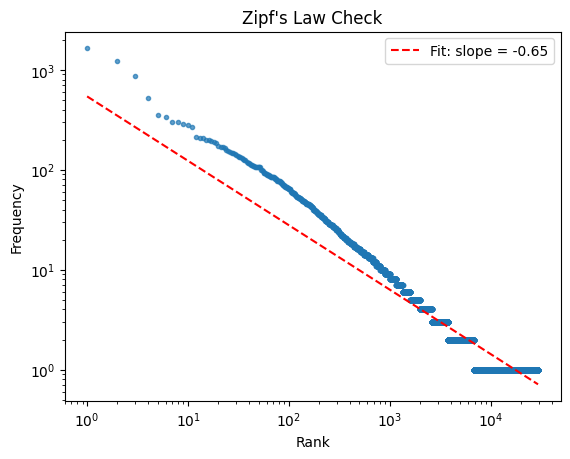

In [4]:
fit_and_visualize_entity_frequencies(unresolved_ents_df)

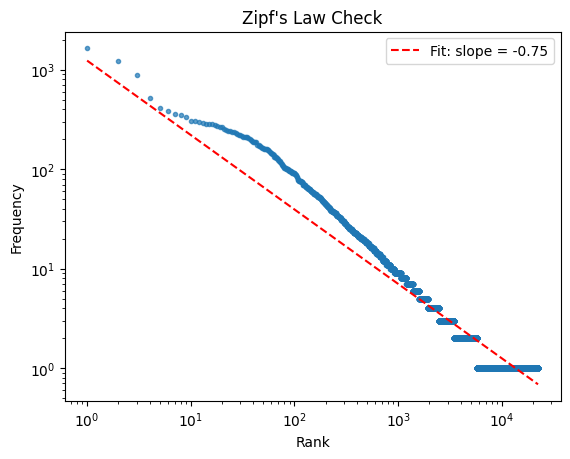

In [5]:
fit_and_visualize_entity_frequencies(resolved_ents_df)

Both roughly fit a Zipfian distribituion. The resolved entities have a slightly steeper slope as "the rich get richer" by adding lower frequency counts of some entities to other entities. Hence, the ranked list becomes shorter, but the total number of entity occurrences are the same.

In this analysis, we are interested in the lower end of the tail: the large number of rare entities. We try to see how these many distinct but rare entities fit into the narrative.

We see a significant portion of hapax legomena – single occurrence entities. While these may also be meaningful, this is also where we see the most noise from extraction errors.

In [6]:
model.entities_[model.entities_.frequency == 1]

,id,label,frequency,doc_frequency,spread,adjusted_tf_idf,alt_labels
16,17,the Great War of the,1,1,0.001203,0.0,[]
18,19,many glimpses,1,1,0.001203,0.0,[]
19,20,the yet more ancient history,1,1,0.001203,0.0,[]
21,22,its publication,1,1,0.001203,0.0,[]
22,23,1937,1,1,0.001203,0.0,[]
...,...,...,...,...,...,...,...
22357,22358,Frodo bore,1,1,0.001203,0.0,[]
22358,22359,the High Sea,1,1,0.001203,0.0,[]
22359,22360,last on a night,1,1,0.001203,0.0,[]
22360,22361,silver glass,1,1,0.001203,0.0,[]


So, from here and onwards we will consider entities with a frequency above 1.

This means that we will filter the graph as follows:

In [7]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_node_frequency=2,
)

## PMI weighting of entity cooccurrences

In our fitted cooccurrence graph, we can calculate pointwise mutual information between entities $A$ and $B$:

$PMI(A, B) = \log \frac{P(A, B)}{P(A)P(B)}$

PMI is known to inflate for rare events. And more generally, it is higher for lower frequency items, as seen below.

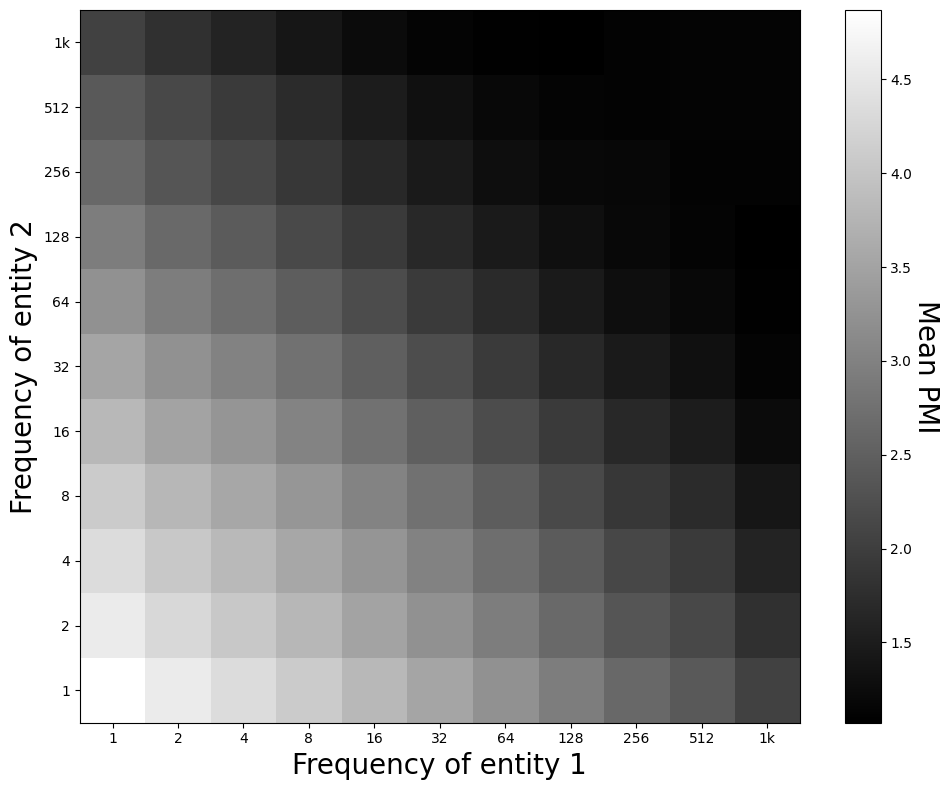

In [8]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

This means – one of the core hypotheses of this analysis – that if we weight edges in our graph with PMI and/or filter edges by PMI, we can surface the rare entity connections as well as particularly strong connections with the more frequent entities.

We can sort of eyeball which area we are interested in: anything above 3 will on average retain half of connections in the 200-300'ish area and therefore even more in the lower end.

In [124]:
min_weight = 2.5

## Community detection

We will use two methods, inspect their results and compare them.

k-clique community detection finds all communities of k-cliques and further merges those that share k-1 nodes. It allows for overlapping communities.

There are two hyperparameters:
- k: the minimum size of a clique. The smaller, the more small cliques we get, but the more merged cliques in bigger communities we get.
- w: the minimum weight of an edge, in our case PMI.

A thing that tends to happen according to the authors of the method is that one giant community tends to show up that eats up a lot of smaller communities and that some of this can be alleviated by tuning on the "right" hyper-parameters. But we may also interpret this differently: this giant community means that whatever micro-narratives are in there are not sufficiently delimited from the general narrative. We will keep this community on the side and not mix them in with the rest of the smaller ones.

For starters, we let k=3 to allow for the smalles meaningful communities. k=2 essentially yields connected components (since it merges all connected nodes) and is therefore too small.

In [206]:
k_clique_comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=min_weight,
    community_detection_method_args=dict(k=4)
)

k_clique_comms_with_contexts = []
k_clique_big_comms = []
last_size = None
for comm in sorted(k_clique_comms, key=lambda c: len(c.members)):
    size = len(comm.members)
    if size < 2:
        continue
    if last_size and size > 2 * last_size:
        k_clique_big_comms.append(comm)
        continue
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    k_clique_comms_with_contexts.append((comm, contexts))
    last_size = size

print(len(k_clique_big_comms))
print(*[len(comm.members) for comm in k_clique_big_comms], sep=', ')

2
114, 3951


Louvain community detection finds communities by optimizing towards modularity, merging smaller communities into bigger ones iteratively while modularity increases. It creates non-overlapping communities.

There are several hyper-parameters, but we consider only:
- resolution: higher values result in smaller communities.
- w: the minimum weight of an edge, in our case PMI.

In [171]:
louvain_comms = model.graph.find_communities(
    graph_filter=graph_filter,
    community_detection_method="louvain",
    min_weight=min_weight,
    community_detection_method_args=dict(resolution=10)
)
louvain_comms_with_contexts = []

for comm in sorted(louvain_comms, key=lambda c: c.score, reverse=True):
    size = len(comm.members)
    if size < 2 or size > 1000 : continue
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    louvain_comms_with_contexts.append((comm, contexts))

Let us get a sense of what kinds of communities we get from the two methods.

## Comparison of k-clique and Louvain

In [207]:
comms_by_method = {
    "k_clique": k_clique_comms_with_contexts,
    "louvain": louvain_comms_with_contexts
}

In [208]:
import numpy as np

# Extract sizes for each method
sizes_by_method = {
    method: [len(comm.members) for comm, contexts in comms_with_contexts]
    for method, comms_with_contexts in comms_by_method.items()
}

for name, comms in sizes_by_method.items():
    print(name)
    print("N:", len(comms))
    print("Mean:", np.mean(comms))
    print("Median:", np.median(comms))
    print()


k_clique
N: 1685
Mean: 7.576261127596439
Median: 6.0

louvain
N: 297
Mean: 19.46127946127946
Median: 19.0



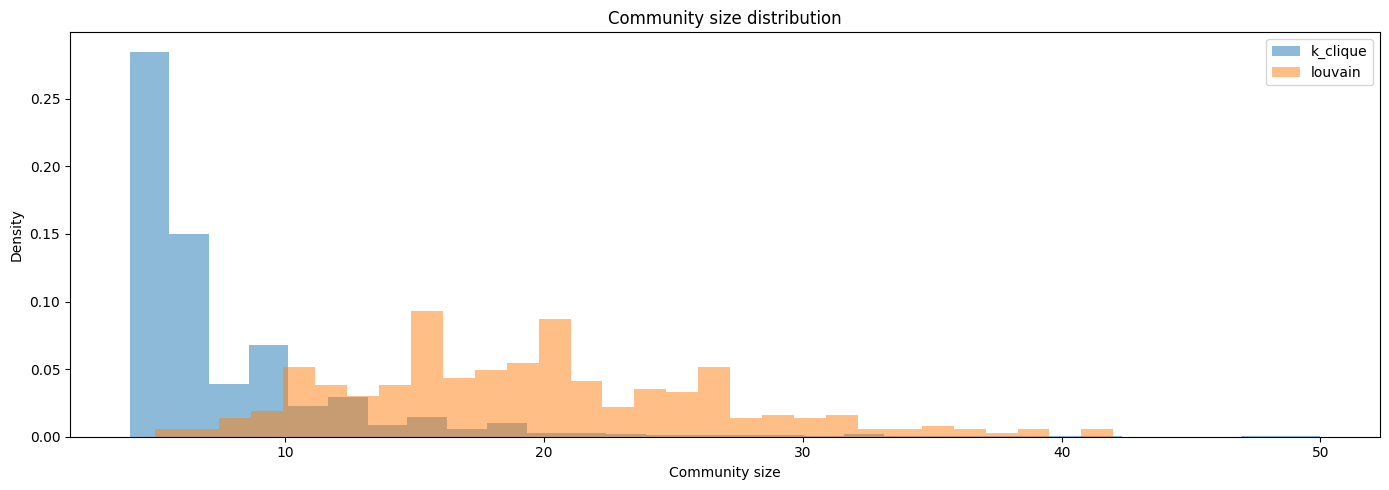

In [209]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(14, 5))

# Barplot: distribution of community sizes
x = np.arange(len(comms_by_method))
width = 0.35

# Density plot: full distributions
for method, sizes in sizes_by_method.items():
    ax.hist(sizes, bins=30, alpha=0.5, label=method, density=True)

ax.set_xlabel('Community size')
ax.set_ylabel('Density')
ax.set_title('Community size distribution')
ax.legend()

plt.tight_layout()
plt.show()

A noticeable difference is that Louvain appears to create fewer but bigger communities than k-clique. We can inspect some of the extracted communities and their contexts as follows.

In [210]:
from sharedutils import print_comm_with_contexts

import random
random.seed(42)
for method, comms_with_contexts in comms_by_method.items():
    print(method)
    sample = random.choices(comms_with_contexts, k=10)
    for comm, contexts in sample[:10]:
        print_comm_with_contexts(comm, contexts)

k_clique
COMMUNITY: one time, the eastern archway, the dark road, a corner, a draught, A chill air, the greater part
ID: 273, OFFSET: 21632
Things have gone well so far, and the greater part of the dark road is over. But we are not through yet, and it is a long way down to the Gates that open on the world.'
     The Company spent that night in the great cavernous hall, huddled close together in a corner to escape the draught: there seemed to be a steady inflow of chill air through the eastern archway. All about them as they lay hung the darkness, hollow and immense, and they were oppressed by the loneliness and vastness of the dolven halls and endlessly branching stairs and passages. The wildest imaginings that dark rumour had ever suggested to the hobbits fell altogether short of the actual dread and wonder of Moria.
     `There must have been a mighty crowd of dwarves here at one time ' said Sam; `and every one of them busier than badgers for five hundred years to make all this, and 

While these are just small samples from the two methods, it provides an important qualitative insight: the smaller communities generally seem more coherent in terms of "a reflected narrative" or thematic connections while the larger communities are more like amalgamations of smaller communities which lack clear coherence.

We will try to test this assumption be seeing whether the smaller communities of one are indeed contained by bigger ones in the other. 

In [213]:
def coverage(list_a: list[set], list_b: list[set]) -> float:
    scores = []
    lengths = []
    for a in list_a:
        if not a:
            continue
        best = max(len(a & b) / len(a) for b in list_b)
        scores.append(best)
        lengths.append(len(a))
    return sum(score * length for score, length in zip(scores, lengths)) / sum(lengths)

k_clique_comm_sets = [{e.id for e in comm.members} for comm, _ in k_clique_comms_with_contexts]
louvain_comm_sets = [{e.id for e in comm.members} for comm, _ in louvain_comms_with_contexts]
k_clique_big_comm_sets = [{e.id for e in comm.members} for comm in k_clique_big_comms]
print("k-clique covered by Louvain:", coverage(k_clique_comm_sets, louvain_comm_sets))
print("Louvain covered by k-clique:", coverage(louvain_comm_sets, k_clique_comm_sets))
print("Louvain covered by giant k-clique comm:", coverage(louvain_comm_sets, k_clique_big_comm_sets))

k-clique covered by Louvain: 0.33628387905373647
Louvain covered by k-clique: 0.2792387543252595
Louvain covered by giant k-clique comm: 0.6892733564013841


Our qualitative assessment is, to some degree, supported by this quantitative evidence. The k-clique communities are in general more contained by the Louvain communities than vice versa. Many of the Louvain communities are covered by the giant k-clique community, however.

In conclusion, for this analysis, where we are interested in micro-narratives – localized configurations of entities that together constitute recognizable subplots or thematic clusters – the smaller communities from k-clique would appear to be more valuable to us.

Therefore, we will dig more into those.

## Typology of k-clique communities

Intuitively, the micro-narratives can appear in a few ways, with these as reference points on a sort of continuum.

1. Appear once
2. Appear multiple times in close vicinity
3. Appear multiple times with great distance

From the earlier qualitative assessment, we saw that many appeared in just one short context snippet in one section of the book. These make up the bulk of the extracted micro-narratives.

### Single-spike micro-narratives

In [214]:
spike_values, spread_values = [], []
for comm, contexts in k_clique_comms_with_contexts:
    ids = {c.doc_id for c in contexts}
    spike_values.append(len(ids))
    spread_values.append(max(ids) - min(ids) + 1)

    
single_spike_count = sum(1 for sv in spike_values if sv == 1)
print('Single spike count:', single_spike_count, 'out of total', len(k_clique_comms_with_contexts))

Single spike count: 657 out of total 1685


We can dig qualitatively into some of these:

In [215]:
for (comm, contexts), sv in zip(k_clique_comms_with_contexts, spike_values):
    if sv > 1: continue
    print('COMMUNITY:', ', '.join(e.label for e in comm.members))
    for context in contexts:
        context.print_with_ansi_highlight()
    print()

COMMUNITY: great strength, a great cry, the threshold, Mortal Men
ID: 714, OFFSET: 12460
And it was said that ever after, if any man looked in that Stone, unless he had a great strength of will to turn it to other purpose, he saw only two aged hands withering in flame.
     Gandalf in grief and horror turned his face away and closed the door. For a while he stood in thought, silent upon the threshold, while those outside heard the greedy roaring of the fire within. And then Denethor gave a great cry, and afterwards spoke no more, nor was ever again seen by mortal men.
     'So passes Denethor, son of Ecthelion,' said Gandalf: Then he turned to Beregond and the Lord's servants that stood there aghast. 'And so pass also the days of Gondor that you have known; for good or evil they are ended. Ill deeds have been done here; but let now all enmity that lies between you be put away, for it was contrived by the Enemy and works his will.

COMMUNITY: all the time, my sort, years, the fireside
I

These do indeed appear to be small clusters of rather specific mentions of rare entities. When one thinks about it, it makes sense that these surface as communities in a PMI-weighted graph: they are the rare connections of rare entities.

However, many of them are not so much delimited narratives as they are specific components of some slightly bigger narrative. As such, they are perhaps best classified as "peripheral narrative elements".

### Multi-spike micro-narratives

We will now dig into multi-spike micro-narratives and see how they are distributed in terms of spread and spikes.

We will operationalize spread as the floored log10 value. This reflects the order of magnitude of sections that a community spreads.

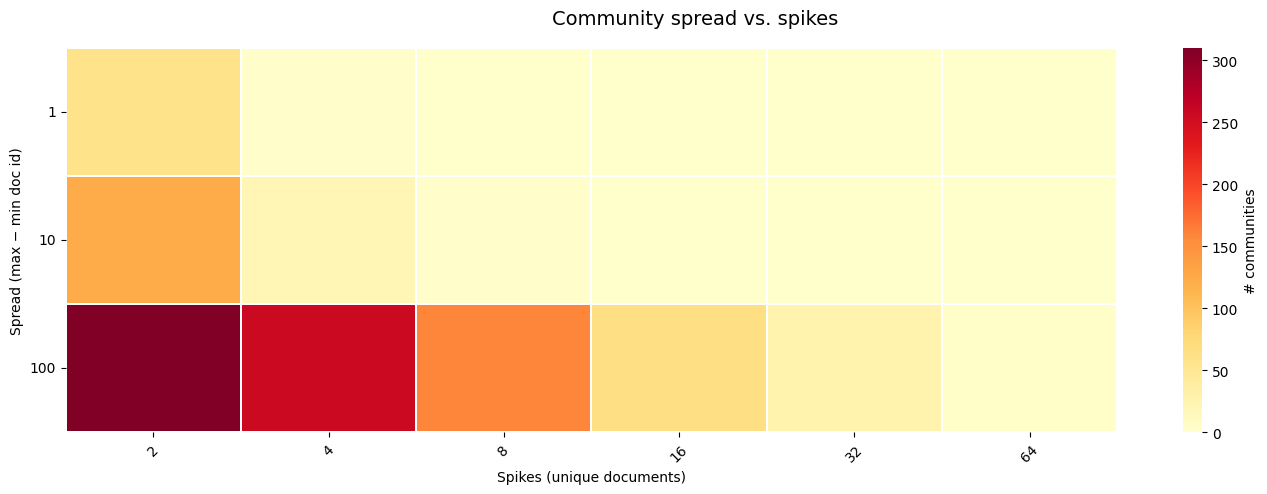

In [216]:
import math
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 5))

df = pd.DataFrame(dict(spikes=spike_values, spread=spread_values))
# remove single spikes
df = df[df.spikes > 1]

log_base = 10
df["floored_log_spread"] = np.floor(np.emath.logn(log_base, df.spread))
df["floored_log_spikes"] = np.floor(np.log2(df.spikes))

# Pivot to a 2D count matrix
heat = (
    df.groupby(["floored_log_spread", "floored_log_spikes"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# Readable tick labels: use bin midpoints
x_labels = [f"{int(2 ** b)}" for b in heat.columns]
y_labels = [f"{int(log_base ** b)}" for b in heat.index]

sns.heatmap(
    heat,
    ax=ax,
    cmap="YlOrRd",
    xticklabels=x_labels,
    yticklabels=y_labels,
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "# communities"},
)

ax.set_xlabel("Spikes (unique documents)")
ax.set_ylabel("Spread (max − min doc id)")
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", rotation=0)

plt.suptitle("Community spread vs. spikes", fontsize=14)
plt.tight_layout()
plt.show()

We will try to dig into these blocks

In [217]:
def activation_score(comm, contexts):
    """A score function to surface those micro-narratives that are the strongest activated in across their contexts"""
    members = {e.id for e in comm.members}
    scores = []
    for context in contexts:
        activated = {e.id for tuplet in context.tuplets
                     for e in [tuplet.entity_one, tuplet.entity_two]}
        scores.append(len(activated) / len(members))
    return np.mean(scores)

def slice_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
    sliced_df = df[
        (min_spread <= df.spread) & 
        (df.spread < max_spread) & 
        (min_spikes <= df.spikes) & 
        (df.spikes < max_spikes)
        ]
    print('Number of comms:', len(sliced_df))
    micro_narratives = [k_clique_comms_with_contexts[row[0]] for row in sliced_df.iterrows()]
    micro_narratives.sort(key=lambda tpl: activation_score(*tpl), reverse=True)
    return micro_narratives
    

def print_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
    for comm, context in slice_micro_narratives(min_spread, max_spread, min_spikes, max_spikes):
        print_comm_with_contexts(comm, context)

#### Adjacent sections, two or three spikes: Local description or event
These are not much longer than the single spike ones, but they do get re-activated across a section boundary.

In [218]:
print_micro_narratives(2, 4, 2, 4)

Number of comms: 21
COMMUNITY: Buckland, the farmer, these outlandish folk, my advice
ID: 63, OFFSET: 11568

     Frodo said nothing: the shrewd guesses of the farmer were rather disconcerting.
     'Well, Mr. Frodo,' Maggot went on, 'I'm glad that you've had the sense to come back to Buckland. My advice is: stay there! And don't get mixed up with these outlandish folk. You'll have friends in these parts. If any of these black fellows come after you again, I'll deal with them.
ID: 65, OFFSET: 1863
That was the origin of Buckland, a thickly inhabited strip between the river and the Old Forest, a sort of colony from the Shire. Its chief village was Bucklebury, clustering in the banks and slopes behind Brandy Hall.
     The people in the Marish were friendly with the Bucklanders, and the authority of the Master of the Hall (as the head of the Brandybuck family was called) was still acknowledged by the farmers between Stock and Rushey. But most of the folk of the old Shire regarded the Buc

#### Low or moderate spread, multiple spikes: Atmospheres, world-building details or sub-plots
These are somewhat more persistent communities across three or more sections, but still limited in the text.

In [219]:
print_micro_narratives(4, 10, 4, 100)

Number of comms: 2
COMMUNITY: the drum-beats, our way, your pack, Doom
ID: 286, OFFSET: 687
We will see what -'
     _Doom, doom_ came the drum-beat and the walls shook.
     'Slam the doors and wedge them! ' shouted Aragorn. 'And keep your packs on as long as you can: we may get a chance to cut our way out yet.'
     `No! ' said Gandalf. 'We must not get shut in.
ID: 289, OFFSET: 54
Doom, doom_ went the drum-beats again: they now sounded muffled and far away, but they were following. There was no other sound of pursuit, neither tramp of feet, nor any voice. Gandalf took no turns, right or left, for the passage seemed to be going in the direction that he desired. Every now and again it descended a flight of steps, fifty or more, to a lower level.
ID: 290, OFFSET: 2158

     Even as he spoke they heard again the pursuing drum-beat: _Doom, doom, doom_. Away beyond the shadows at the western end of the hall there came cries and horn-calls. _Doom, doom_: the pillars seemed to tremble an

In [220]:
print_micro_narratives(10, 100, 4, 100)

Number of comms: 22
COMMUNITY: the Withywindle, the forest, all the stories, the bog
ID: 65, OFFSET: 2802
It ran all the way from Brandywine Bridge, in a big loop curving away from the river, to Haysend (where the Withywindle flowed out of the Forest into the Brandywine): well over twenty miles from end to end. But, of course, it was not a complete protection. The Forest drew close to the hedge in many places. The Bucklanders kept their doors locked after dark, and that also was not usual in the Shire.
ID: 79, OFFSET: 1797
Near at hand the mist was now almost gone; though here and there it lay in hollows of the wood, and to the south of them, out of a deep fold cutting right across the Forest, the fog still rose like steam or wisps of white smoke.
     'That,' said Merry, pointing with his hand, 'that is the line of the Withywindle. It comes down out of the Downs and flows south-west through the midst of the Forest to join the Brandywine below Haysend. We don't want to go _that_ way! T

#### High spread, few spikes: Cross-textual echoes

In [202]:
print_micro_narratives(10, 100, 2, 4)

Number of comms: 9
COMMUNITY: my pouch, all the mischief, Saruman
ID: 799, OFFSET: 6373
In that case I will have my pouch back, which is not yours and has journeyed far with me. Wrap the weed in a rag of your own.'
     'One thief deserves another,' said Saruman, and turned his back on Merry, and kicked Wormtongue, and went away towards the wood.
     'Well, I like that!'
ID: 814, OFFSET: 7889
If I had known all the mischief he had caused, I should have stuffed my pouch down Saruman's throat.'
     'No doubt, no doubt! But you did not, and so I am able to welcome you home.' There standing at the door was Saruman himself, looking well-fed and well-pleased; his eyes gleamed with malice and amusement.

COMMUNITY: the bank, Spring, a rill, the search
ID: 353, OFFSET: 646
I cannot tell whether any of the hobbits have come back since the search for Frodo began.' He returned to the bank, close to where the rill from the spring trickled out into the River. 'There are some clear prints here,' h

In [203]:
print_micro_narratives(100, 1000, 2, 4)

Number of comms: 21
COMMUNITY: that vile creature, the past, a chance, What a pity
ID: 43, OFFSET: 1818
What a pity that Bilbo did not stab that vile creature, when he had a chance!'
     'Pity? It was Pity that stayed his hand. Pity, and Mercy: not to strike without need.
ID: 515, OFFSET: 6198

     It seemed to Frodo then that he heard, quite plainly but far off, voices out of the past:
     _What a pity Bilbo did not stub the vile creature, when he had a chance!_
     _Pity? It was Pity that stayed his hand. Pity, and Mercy: not to strike without need._

COMMUNITY: any rate, a wraith, Morgulduin
ID: 167, OFFSET: 1162
Already they were getting used to much walking on short commons  shorter at any rate than what in the Shire they would have thought barely enough to keep them on their legs. Pippin declared that Frodo was looking twice the hobbit that he had been.
     'Very odd,' said Frodo, tightening his belt, 'considering that there is actually a good deal less of me. I hope the th

#### High spread, multiple spikes: recurring narrative elements and motifs

In [204]:
print_micro_narratives(100, 1000, 4, 8)

Number of comms: 12
COMMUNITY: the door, And whither, the road, many paths, weary feet
ID: 23, OFFSET: 26707
What fun to be off again, off on the Road with dwarves! This is what I have really been longing for, for years! Good-bye! ' he said, looking at his old home and bowing to the door. '
ID: 24, OFFSET: 0
The Road goes ever on and on
            Down from the door where it began.
            Now far ahead the Road has gone,
            And I must follow, if I can,
           Pursuing it with eager feet,
            Until it joins some larger way
           Where many paths and errands meet.
            And whither then? I cannot say.
ID: 48, OFFSET: 0
The Road goes ever on and on
            Down from the door where it began.
           Now far ahead the Road has gone,
            And I must follow, if I can,
           Pursuing it with weary feet,
            Until it joins some larger way,
           Where many paths and errands meet.
            And whither then? I cannot say.
ID

In [205]:
print_micro_narratives(100, 1000, 8, 16)

Number of comms: 6
COMMUNITY: a second darkness, the point, the next day, the last gasp, a change, the day
ID: 23, OFFSET: 0
The next day more carts rolled up the Hill, and still more carts. There might have been some grumbling about 'dealing locally', but that very week orders began to pour out of Bag End for every kind of provision, commodity, or luxury that could be obtained in Hobbiton or Bywater or anywhere in the neighbourhood. People became enthusiastic; and they began to tick off the days on the calendar; and they watched eagerly for the postman, hoping for invitations.
     Before long the invitations began pouring out, and the Hobbiton post-office was blocked, and the Bywater post-office was snowed under, and voluntary assistant postmen were called for.
ID: 25, OFFSET: 4371
When she arrived later in the day, she took the point at once, but she also took the spoons.
     This is only a small selection of the assembled presents. Bilbo's residence had got rather cluttered up wit